<a href="https://colab.research.google.com/github/Walbyq/beer-sales-predicting/blob/main/beer_sales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Установка библиотек

In [3]:
# !pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 20.3 MB/s eta 0:00:00


# Импорт библиотек

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler

from datetime import datetime, timedelta
from tabulate import tabulate

# Загрузка файлов

In [5]:
# Подключение к Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [6]:
import os
path = '/content/drive/MyDrive/data/data_for_test_arch'

# Просмотр файлов в папке
files = os.listdir(path)
print(files)

['beer_sales_data.parquet', 'ana_sales_data.parquet', 'cig_sales_data.parquet', 'demographic_data.parquet', 'cig_upc.parquet', 'ana_upc.parquet', 'beer_upc.parquet']


Для анализа возьмем набор данных о продажах пива

In [7]:
# Загрузка данных
beer_sales_df = pd.read_parquet(f"{path}/beer_sales_data.parquet")
beer_upc_df = pd.read_parquet(f"{path}/beer_upc.parquet", columns=['upc', 'descrip'])

# Анализ данных

## Основная информация

In [8]:
# Функция для красивого отображения датафреймов
def tabulate_df(df):
    return print(tabulate(df, headers='keys', tablefmt='psql'))

# Вывод информации о датафрейме
print("="*20, "Данные о продажах пива:", "="*20)
tabulate_df(beer_sales_df.head())
tabulate_df(beer_upc_df.head())
print("\nРазмерность:", beer_sales_df.shape)
print("\nПустые значения:")
print(beer_sales_df.isnull().sum())
print("\nСтатистическое описание:")
print(tabulate_df(beer_sales_df.describe()))
print("\nОсновная информация:")
print(beer_sales_df.info())

==================== Данные о продажах пива: ====================
+----+---------+-------+--------+--------+-------+---------+--------+
|    |   store |   upc |   week |   move |   qty |   price | sale   |
|----+---------+-------+--------+--------+-------+---------+--------|
|  0 |       2 |   294 |    298 |     11 |     1 |    2.62 |        |
|  1 |       2 |   294 |    299 |      9 |     1 |    2.51 |        |
|  2 |       2 |   294 |    300 |      6 |     1 |    2.49 |        |
|  3 |       2 |   294 |    301 |      5 |     1 |    2.99 |        |
|  4 |       2 |   294 |    302 |      1 |     1 |    2.49 |        |
+----+---------+-------+--------+--------+-------+---------+--------+
+----+-------+----------------------+
|    |   upc | descrip              |
|----+-------+----------------------|
|  0 |   294 | BEER LIMIT           |
|  1 |   307 | HEINEKEN KINGSIZE CA |
|  2 |   710 | BUDWEISER BEER       |
|  3 |   711 | BUDWEISER DRY BEER   |
|  4 |   712 | BUDWEISER LIGHT BEER |


Удалим ненужные строки, в которых не было продаж

In [9]:
beer_sales_df = beer_sales_df[beer_sales_df['move'] != 0]

Столбец *sale* содержит пустые значения, исправим это, заменив пустые строки на 0, если товар был преобретен без скидки и на 1, если товар был со скидкой. Также удалим недели с нулевыми продажами

In [10]:
beer_sales_df['sale'] = beer_sales_df['sale'].apply(lambda x: False if x is None else True)

Из статистического описания таблицы *beer_sales_data* мы видим, что в ней присутствуют значения *qty* = 2 (кол-во предметов, упакованных вместе). Рассмотрим эти значения:

In [11]:
# Фильтрация по количеству 'qty' равному 2
print("Продажи с параметром 'qty' = 2:")
filtered_qty = beer_sales_df[beer_sales_df['qty'] == 2]
print(tabulate_df(filtered_qty.head()))

# Фильтрация по UPC
print("\nПрочие продажи одного из перечисленных товаров:")
filtered_upc = beer_sales_df[beer_sales_df['upc'] == 8797502650]
print(tabulate_df(filtered_upc.head()))

Продажи с параметром 'qty' = 2:
+---------+---------+------------+--------+--------+-------+---------+--------+
|         |   store |        upc |   week |   move |   qty |   price | sale   |
|---------+---------+------------+--------+--------+-------+---------+--------|
|  980319 |      95 | 3410015505 |    140 |    142 |     2 |       5 | True   |
| 1083765 |      95 | 3410017505 |    140 |    769 |     2 |       5 | True   |
| 1342399 |      95 | 3410057505 |    140 |    578 |     2 |       5 | False  |
| 3776134 |      14 | 8797502650 |    151 |      1 |     2 |       3 | True   |
| 3776135 |      14 | 8797502650 |    152 |     13 |     2 |       3 | False  |
+---------+---------+------------+--------+--------+-------+---------+--------+
None

Прочие продажи одного из перечисленных товаров:
+---------+---------+------------+--------+--------+-------+---------+--------+
|         |   store |        upc |   week |   move |   qty |   price | sale   |
|---------+---------+------------+

Видим, что цена на них выше, чем при *qty* = 1, даже при условии, что они преобретены по скидке. Делаем вывод, что цена указана не за единицу товара, а за упаковку. Приведем все значения к *qty* = 1:

In [12]:
# Меняем количество проданного товара и цену
beer_sales_df['move'] = beer_sales_df['move'] * beer_sales_df['qty']
beer_sales_df['price'] = beer_sales_df['price'] / beer_sales_df['qty']

In [13]:
# Удаляем ненужные столбцы
beer_sales_df = beer_sales_df.drop(columns=['qty','store', 'upc'])
tabulate_df(beer_sales_df.head())

+----+--------+--------+---------+--------+
|    |   week |   move |   price | sale   |
|----+--------+--------+---------+--------|
|  0 |    298 |     11 |    2.62 | False  |
|  1 |    299 |      9 |    2.51 | False  |
|  2 |    300 |      6 |    2.49 | False  |
|  3 |    301 |      5 |    2.99 | False  |
|  4 |    302 |      1 |    2.49 | False  |
+----+--------+--------+---------+--------+


## Визуализация

Каждому порядковому номеру недели поставим в соответствие дату. Даты возьмем из мануала https://www.chicagobooth.edu/research/kilts/research-data/-/media/enterprise/centers/kilts/datasets/dominicks-dataset/dominicks-manual-and-codebook_kiltscenter

In [14]:
# Начальная дата первой недели
start_date = datetime.strptime('09/14/1989', '%m/%d/%Y')

# Функция для получения даты начала недели
def get_start_date_of_week(week_num):
    return start_date + timedelta(weeks=week_num - 1)

# Добавляем дату
beer_sales_df['date'] = beer_sales_df['week'].apply(get_start_date_of_week)

print("Объем продаж пива в неделю, начиная с указанной даты:")
tabulate_df(beer_sales_df.head())

Объем продаж пива в неделю, начиная с указанной даты:
+----+--------+--------+---------+--------+---------------------+
|    |   week |   move |   price | sale   | date                |
|----+--------+--------+---------+--------+---------------------|
|  0 |    298 |     11 |    2.62 | False  | 1995-05-25 00:00:00 |
|  1 |    299 |      9 |    2.51 | False  | 1995-06-01 00:00:00 |
|  2 |    300 |      6 |    2.49 | False  | 1995-06-08 00:00:00 |
|  3 |    301 |      5 |    2.99 | False  | 1995-06-15 00:00:00 |
|  4 |    302 |      1 |    2.49 | False  | 1995-06-22 00:00:00 |
+----+--------+--------+---------+--------+---------------------+


Агрегируем данные по параметрам

In [15]:
# Задаем недели праздников
holiday_dates = {
    '4th of July': [95, 147, 199, 251, 303, 356],
    'Labor Day': [103, 156, 208, 260, 312, 364],
    'Halloween': [112, 164, 216, 268, 320, 372],
    'Thanksgiving': [116, 168, 220, 272, 324, 377],
    'Christmas': [119, 172, 224, 276, 328, 380],
    'New Year': [120, 173, 225, 277, 329, 381],
    'Presidents Day': [128, 180, 232, 284, 336, 389],
    'Easter': [133, 185, 238, 289, 341, 393],
    'Memorial Day': [141, 194, 256, 298, 350],
}

# Функция определения сезона на основе месяца
def get_season(month):
    if month in [12, 1, 2]: return 'Winter'
    elif month in [3, 4, 5]: return 'Spring'
    elif month in [6, 7, 8]: return 'Summer'
    else: return 'Autumn'

# Функция для определения праздника или обычного дня
def get_holiday(week):
    for holiday_name, weeks in holiday_dates.items():
        if week in weeks: return holiday_name
    return 'Ordinary'

# Функция для агрегации по различным параметрам
def aggregate_sales(df, col):
    # Агрегация по заданному столбцу
    sales = df.groupby(col)['move'].sum().reset_index()
    count = df.groupby(col)['date'].count().reset_index(name='count')

    # Объединение данных
    aggregated = sales.merge(count, on=col)

    # Расчет средней продажи
    aggregated['avg_move'] = aggregated['move'] / aggregated['count']

    return aggregated

# Добавление столбцов недели и праздника
beer_sales_df['season'] = beer_sales_df['date'].dt.month.apply(get_season)
beer_sales_df['holiday'] = beer_sales_df['week'].apply(get_holiday)

# Агрегация
price_sales = aggregate_sales(beer_sales_df, 'price')
sale_sales = aggregate_sales(beer_sales_df, 'sale')
season_sales = aggregate_sales(beer_sales_df, 'season')
holiday_sales = aggregate_sales(beer_sales_df, 'holiday')

# Вывод результатов
print("Агрегация по цене:")
tabulate_df(price_sales.head())
print("\nАгрегация по скидке:")
tabulate_df(sale_sales.head())
print("\nАгрегация по сезону:")
tabulate_df(season_sales.head())
print("\nАгрегация по празднику:")
tabulate_df(holiday_sales.head(20))

Агрегация по цене:
+----+---------+--------+---------+------------+
|    |   price |   move |   count |   avg_move |
|----+---------+--------+---------+------------|
|  0 |    0.01 |      1 |       1 |     1      |
|  1 |    0.79 |     50 |       2 |    25      |
|  2 |    0.92 |      7 |       1 |     7      |
|  3 |    0.95 |     10 |       1 |    10      |
|  4 |    0.99 |  27348 |     458 |    59.7118 |
+----+---------+--------+---------+------------+

Агрегация по скидке:
+----+--------+---------+---------+------------+
|    | sale   |    move |   count |   avg_move |
|----+--------+---------+---------+------------|
|  0 | False  | 7284594 | 1421392 |    5.12497 |
|  1 | True   | 6143458 |  544756 |   11.2774  |
+----+--------+---------+---------+------------+

Агрегация по сезону:
+----+----------+---------+---------+------------+
|    | season   |    move |   count |   avg_move |
|----+----------+---------+---------+------------|
|  0 | Autumn   | 2975497 |  460938 |    6.45531 

Построим графики распределения

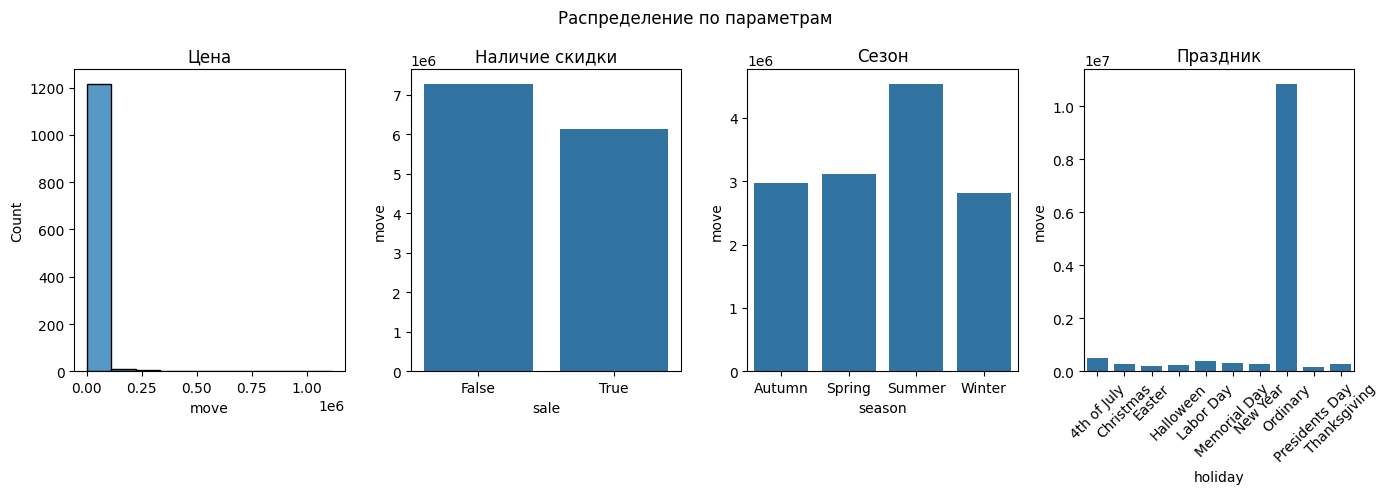

In [16]:
fig, axes = plt.subplots(1, 4, figsize=(14, 5))
plt.suptitle('Распределение по параметрам')

# Гистограмма средних продаж по цене
sns.histplot(price_sales['move'], bins=10, ax=axes[0])
axes[0].set_title('Цена')

# График средних продаж по наличию скидки
sns.barplot(x='sale', y='move', data=sale_sales, ax=axes[1])
axes[1].set_title('Наличие скидки')

# График средних продаж по сезонам
sns.barplot(x='season', y='move', data=season_sales, ax=axes[2])
axes[2].set_title('Сезон')

# График средних продаж по сезонам
sns.barplot(x='holiday', y='move', data=holiday_sales, ax=axes[3])
axes[3].set_title('Праздник')
# Поворот подписей
axes[3].set_xticks(range(len(holiday_sales['holiday'])))
axes[3].set_xticklabels(axes[3].get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()

Проанализируем зависимость спроса от цены, скидки, сезона и праздника

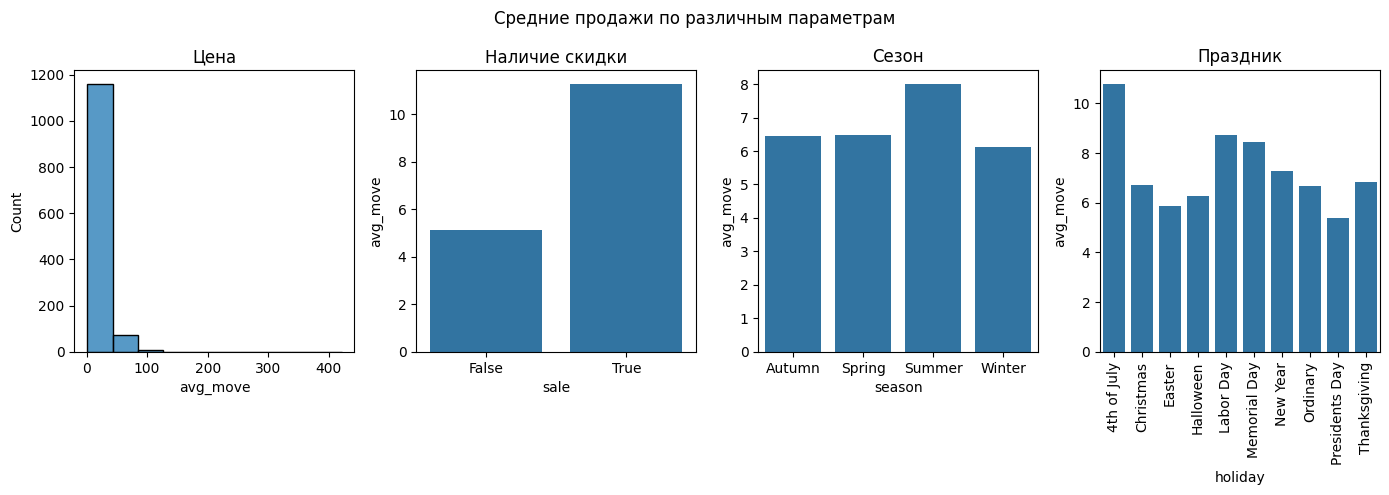

In [32]:
fig, axes = plt.subplots(1, 4, figsize=(14, 5))
plt.suptitle('Средние продажи по различным параметрам')

# Гистограмма средних продаж по цене
sns.histplot(price_sales['avg_move'], bins=10, ax=axes[0])
axes[0].set_title('Цена')

# График средних продаж по наличию скидки
sns.barplot(x='sale', y='avg_move', data=sale_sales, ax=axes[1])
axes[1].set_title('Наличие скидки')

# График средних продаж по сезонам
sns.barplot(x='season', y='avg_move', data=season_sales, ax=axes[2])
axes[2].set_title('Сезон')

# График средних продаж по сезонам
sns.barplot(x='holiday', y='avg_move', data=holiday_sales, ax=axes[3])
axes[3].set_title('Праздник')

# Поворот подписей
axes[3].set_xticks(range(len(holiday_sales['holiday'])))
axes[3].set_xticklabels(axes[3].get_xticklabels(), rotation=90)

plt.tight_layout()
plt.show()

По графикам видно:
- При увеличении цены спрос падает
- Сниженная цена значительно привлекает покупателей
- В теплые сезоны люди хотят пить больше пива
- Спрос значительно увеличивается на День Независимости, немного на День Труда и День Памяти, а в остальные праздники не сильно отклоняется от продаж в обычные дни

## Временной ряд

In [19]:
tabulate_df(beer_sales_df.head())
print("Строк: ", beer_sales_df.shape[0])

+----+--------+--------+---------+--------+---------------------+----------+--------------+
|    |   week |   move |   price | sale   | date                | season   | holiday      |
|----+--------+--------+---------+--------+---------------------+----------+--------------|
|  0 |    298 |     11 |    2.62 | False  | 1995-05-25 00:00:00 | Spring   | Memorial Day |
|  1 |    299 |      9 |    2.51 | False  | 1995-06-01 00:00:00 | Summer   | Ordinary     |
|  2 |    300 |      6 |    2.49 | False  | 1995-06-08 00:00:00 | Summer   | Ordinary     |
|  3 |    301 |      5 |    2.99 | False  | 1995-06-15 00:00:00 | Summer   | Ordinary     |
|  4 |    302 |      1 |    2.49 | False  | 1995-06-22 00:00:00 | Summer   | Ordinary     |
+----+--------+--------+---------+--------+---------------------+----------+--------------+
Строк:  1966148


In [20]:
# Агрегирование данных
beer_sales_df = beer_sales_df.groupby('date').agg({
    'move': 'sum',
    'price': 'mean',
    'sale': 'mean',
    'season': 'first',
    'holiday': 'first',
    'week': 'first'
}).reset_index()

# Печать результата
tabulate_df(beer_sales_df.head())
print("Строк: ", beer_sales_df.shape[0])

+----+---------------------+--------+---------+----------+----------+-------------+--------+
|    | date                |   move |   price |     sale | season   | holiday     |   week |
|----+---------------------+--------+---------+----------+----------+-------------+--------|
|  0 | 1991-06-06 00:00:00 |  58515 | 5.31675 | 0.185256 | Summer   | Ordinary    |     91 |
|  1 | 1991-06-13 00:00:00 |  70570 | 5.30955 | 0.18493  | Summer   | Ordinary    |     92 |
|  2 | 1991-06-20 00:00:00 |  69579 | 5.20263 | 0.258914 | Summer   | Ordinary    |     93 |
|  3 | 1991-06-27 00:00:00 |  70108 | 5.04007 | 0.196081 | Summer   | Ordinary    |     94 |
|  4 | 1991-07-04 00:00:00 | 100298 | 5.13956 | 0.174063 | Summer   | 4th of July |     95 |
+----+---------------------+--------+---------+----------+----------+-------------+--------+
Строк:  302


Восполним недостающие даты

In [21]:
# Определяем минимальное и максимальное значение даты
min_date = beer_sales_df['date'].min()
max_date = beer_sales_df['date'].max()

# Создаем полный диапазон дат от min до max с шагом в неделю
full_range = pd.date_range(start=min_date, end=max_date, freq='W-Thu').to_frame(index=False, name='date')

# Объединяем с оригинальным датафреймом
beer_sales_df = full_range.merge(beer_sales_df, on='date', how='left')

# Заполняем пропуски
beer_sales_df['move'] = beer_sales_df['move'].fillna(0)
beer_sales_df['price'] = beer_sales_df['price'].fillna(beer_sales_df['price'].mean())
beer_sales_df['sale'] = beer_sales_df['sale'].fillna(beer_sales_df['sale'].mean())
beer_sales_df['season'] = beer_sales_df['season'].fillna(beer_sales_df['date'].dt.month.apply(get_season))
beer_sales_df['holiday'] = beer_sales_df['holiday'].fillna(beer_sales_df['week'].apply(get_holiday))

tabulate_df(beer_sales_df.head())
print("Строк после добавления пропущенных дат: ", beer_sales_df.shape[0])

+----+---------------------+--------+---------+----------+----------+-------------+--------+
|    | date                |   move |   price |     sale | season   | holiday     |   week |
|----+---------------------+--------+---------+----------+----------+-------------+--------|
|  0 | 1991-06-06 00:00:00 |  58515 | 5.31675 | 0.185256 | Summer   | Ordinary    |     91 |
|  1 | 1991-06-13 00:00:00 |  70570 | 5.30955 | 0.18493  | Summer   | Ordinary    |     92 |
|  2 | 1991-06-20 00:00:00 |  69579 | 5.20263 | 0.258914 | Summer   | Ordinary    |     93 |
|  3 | 1991-06-27 00:00:00 |  70108 | 5.04007 | 0.196081 | Summer   | Ordinary    |     94 |
|  4 | 1991-07-04 00:00:00 | 100298 | 5.13956 | 0.174063 | Summer   | 4th of July |     95 |
+----+---------------------+--------+---------+----------+----------+-------------+--------+
Строк после добавления пропущенных дат:  309


In [22]:
# Удаляем столбец 'week'
beer_sales_df = beer_sales_df.drop(columns=['week'])

In [23]:
# Установка даты в качестве индекса
beer_sales_df = beer_sales_df.set_index('date')

# Задаем недельную частоту, начиная с четверга
beer_sales_df.index.freq = 'W-THU'

# Задаем периодичность (52 недели в году)
forecast_periods = 52

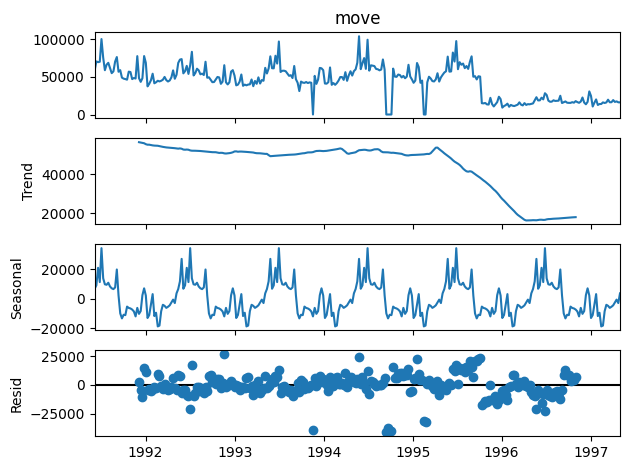

In [24]:
# Декомпозиция временного ряда
decomposition = seasonal_decompose(beer_sales_df['move'],
                                   model='additive', period=forecast_periods)
decomposition.plot()
plt.show()

Видим, что сезонность и тренд присутствуют

In [25]:
# Проверка стационарности с помощью теста Дики-Фуллера
def test_stationarity(timeseries):
    result = adfuller(timeseries)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    if result[1] <= 0.05:
        print("Ряд стационарен")
    else:
        print("Ряд не стационарен")

test_stationarity(beer_sales_df['move'])

ADF Statistic: -2.7143134293992444
p-value: 0.07159400192095688
Ряд не стационарен


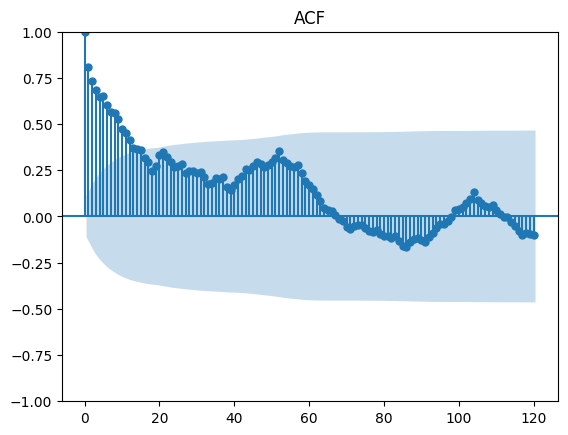

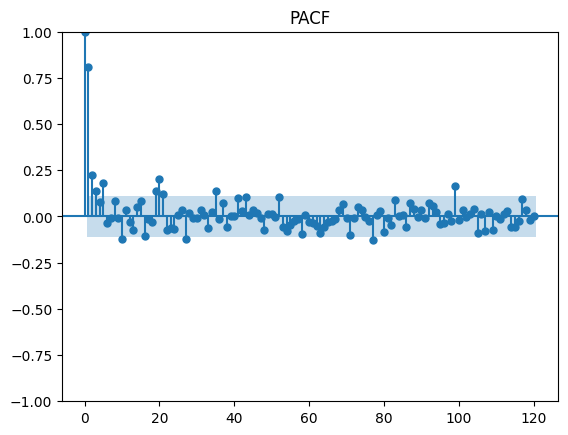

In [26]:
# Построение ACF и PACF
plot_acf(beer_sales_df['move'], lags=120)
plt.title('ACF')
plt.show()

plot_pacf(beer_sales_df['move'], lags=120)
plt.title('PACF')
plt.show()

In [27]:
# # Автоматический подбор параметров ARIMA/SARIMA
# model = auto_arima(beer_sales_df['move'], seasonal=True,
#                    m=forecast_periods, stepwise=True, trace=True)

# Предобработка данных

In [28]:
# Нормализация числовых переменных
scaler = MinMaxScaler()
beer_sales_df[['price', 'sale']] = scaler.fit_transform(beer_sales_df[['price', 'sale']])

# One-hot encoding категориальных переменных
beer_sales_df = pd.get_dummies(beer_sales_df, columns=['season', 'holiday'], drop_first=True)

# Меняем столбцы типа bool на int для SARIMAX
categorical_cols = beer_sales_df.select_dtypes(include=['bool']).columns
beer_sales_df[categorical_cols] = beer_sales_df[categorical_cols].astype(int)

tabulate_df(beer_sales_df.head())

+---------------------+--------+-----------+----------+-----------------+-----------------+-----------------+---------------------+------------------+---------------------+---------------------+------------------------+--------------------+--------------------+--------------------------+------------------------+
| date                |   move |     price |     sale |   season_Spring |   season_Summer |   season_Winter |   holiday_Christmas |   holiday_Easter |   holiday_Halloween |   holiday_Labor Day |   holiday_Memorial Day |   holiday_New Year |   holiday_Ordinary |   holiday_Presidents Day |   holiday_Thanksgiving |
|---------------------+--------+-----------+----------+-----------------+-----------------+-----------------+---------------------+------------------+---------------------+---------------------+------------------------+--------------------+--------------------+--------------------------+------------------------|
| 1991-06-06 00:00:00 |  58515 | 0.207559  | 0.220875 |   

# Обучение

In [29]:
# Параметры обучения
p, d, q = 2, 1, 1
P, D, Q, s = 1, 0, 0, forecast_periods

# Определение модели ARIMAX
model = SARIMAX(beer_sales_df['move'],
                exog = beer_sales_df.drop(columns=['move']),
                order=(p, d, q),
                seasonal_order=(P, D, Q, s))

# Обучение модели
results = model.fit()

Среднеквадратическая ошибка (MSE): 128738793.84547718
Средняя абсолютная ошибка (MAE): 6770.8357040891815


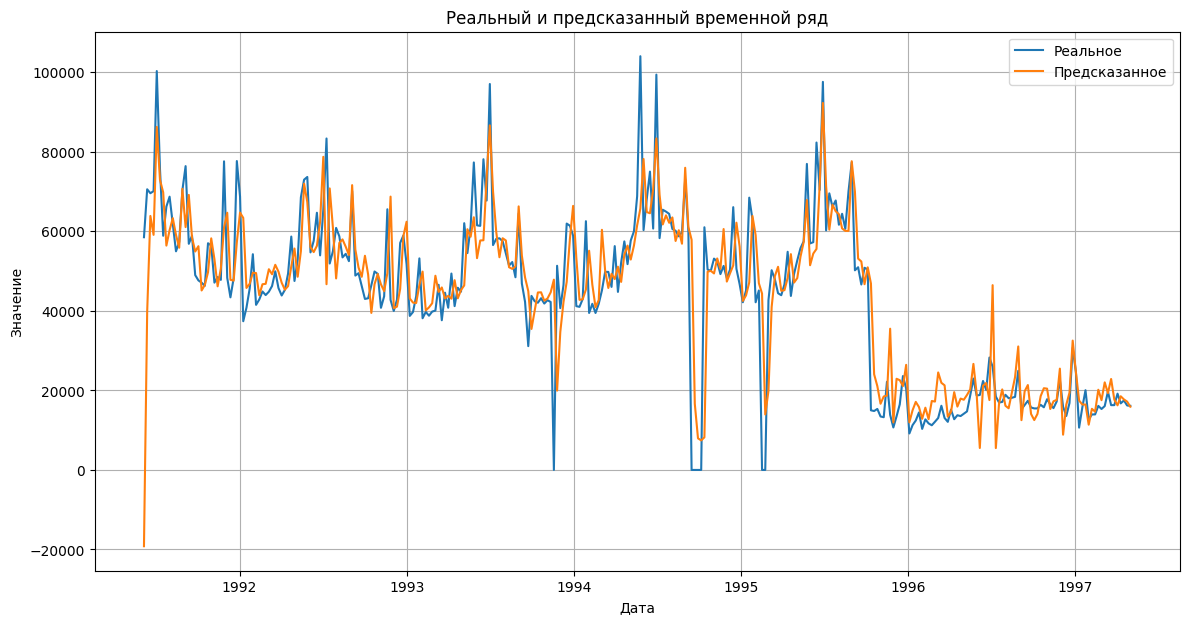

In [30]:
# Оценка обучения
predictions = results.predict(start=beer_sales_df.index[0], end=beer_sales_df.index[-1])

# Вычисление MSE
mse = mean_squared_error(beer_sales_df['move'], predictions)
print('Среднеквадратическая ошибка (MSE):', mse)

# Вычисление MAE
mae = mean_absolute_error(beer_sales_df['move'], predictions)
print('Средняя абсолютная ошибка (MAE):', mae)

# График реального и предсказанного временного ряда
plt.figure(figsize=(14, 7))
plt.plot(beer_sales_df.index, beer_sales_df['move'], label='Реальное')
plt.plot(predictions.index, predictions, label='Предсказанное')

plt.legend()
plt.title('Реальный и предсказанный временной ряд')
plt.xlabel('Дата')
plt.ylabel('Значение')
plt.grid()
plt.show()

# Предсказание

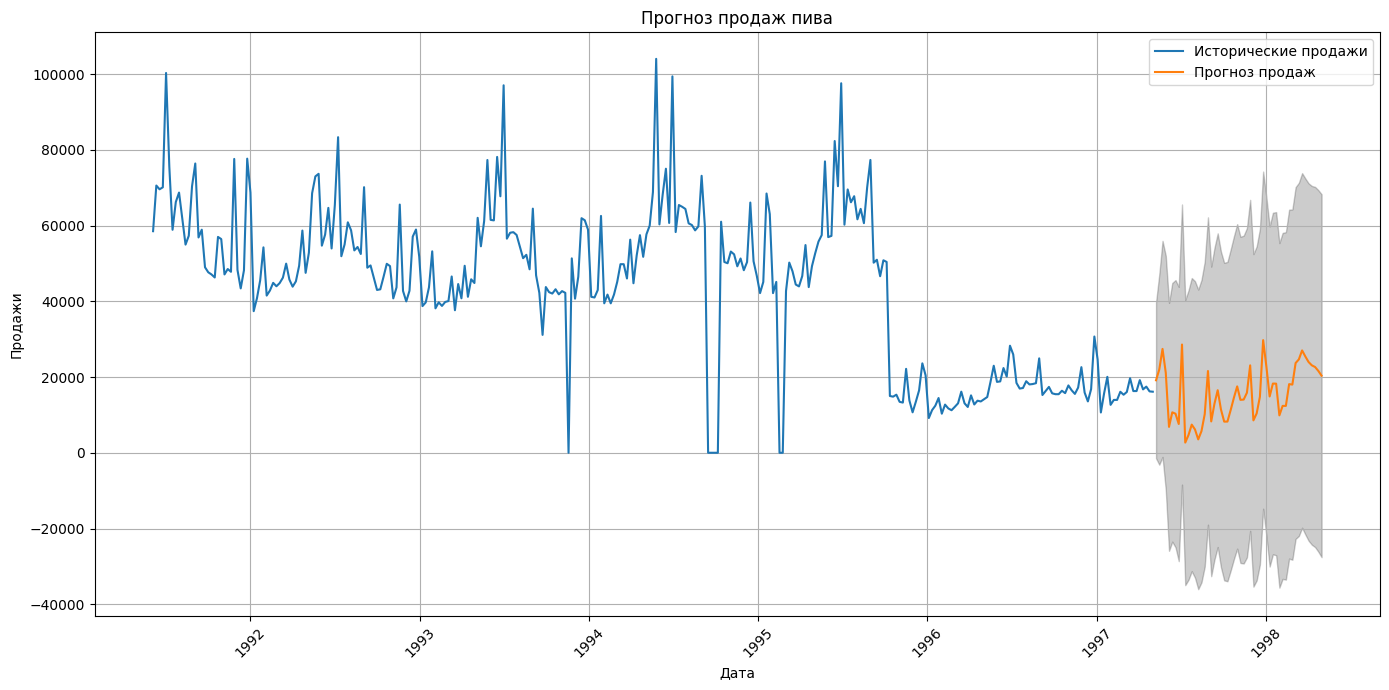

In [31]:
# Создание future_exog на основе последнего года
exog = beer_sales_df.drop(columns=['move']).tail(52)

# Прогнозирование
forecast = results.get_forecast(steps=forecast_periods, exog=exog)
forecast_mean = forecast.predicted_mean
conf_int = forecast.conf_int()

# Создание диапазона дат для прогноза
last_date = beer_sales_df.index[-1]
forecast_index = pd.date_range(start=last_date + pd.DateOffset(weeks=1), periods=forecast_periods, freq='W-Thu')

# Визуализация прогноза
plt.figure(figsize=(14, 7))
plt.plot(beer_sales_df.index, beer_sales_df['move'], label='Исторические продажи')
plt.plot(forecast_index, forecast_mean.values, label='Прогноз продаж')
plt.fill_between(forecast_index,
                 conf_int.iloc[:, 0],
                 conf_int.iloc[:, 1],
                 color='k', alpha=0.2)
plt.title('Прогноз продаж пива')
plt.xlabel('Дата')
plt.ylabel('Продажи')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()